# Import Library

In [1]:
# Import External Library
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.metrics import MeanSquaredError
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os 
import glob
from timeit import default_timer as timer
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Import own library
from function.preprocess import *
from function.eval_netrics import *

# Read CSV Data

In [10]:
# Read Data Train
df_train = pd.read_csv(r'...\SET1\train_set1.csv')
df_val = pd.read_csv('...\PID TEST\Cirrus1.csv')

In [14]:
features_col = ['error_rate','yaw_error', 'phi']
targets_col = ['JSRoll_Sim']

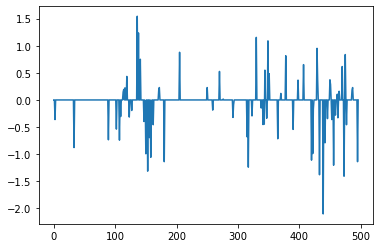

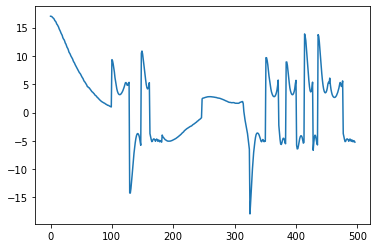

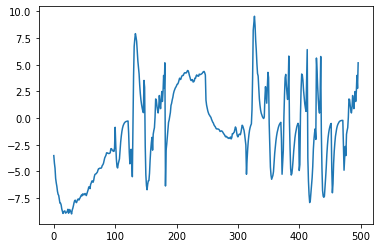

In [15]:
for value in features_col:
    plt.plot(df_train[value])
    plt.title(df_train[value])
    plt.show()

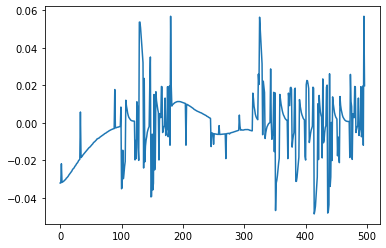

In [16]:
plt.plot(df_train['JSRoll_Sim'])

# Create Feature & Target Data 

In [17]:
X_train = df_train[features_col].values.astype('float32')
X_val = df_val[features_col].values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
transformer = scaler.fit(X_train)
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)


y_train = df_train[targets_col].values.astype('float32')
y_val = df_val[targets_col].values.astype('float32')

# Define model function

## Keras Tuner

In [18]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,Bidirectional,LSTM,Bidirectional, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import TensorBoard
from keras.constraints import maxnorm


hp = kt.HyperParameters()

def call_existing_ANN(units1, units_hidden, activation,initializer, activation_hidden, optimizer, dropout,do_rate, lr, num_hidden, x_train, y_train):
    model = Sequential()                            
    model.add(Dense(units=units1,
                    input_dim=(x_train.shape[1]),
                    kernel_initializer=initializer))
    
    # Add Hidden layers
    for i in range(num_hidden):
        model.add(Dense(units=units_hidden,
                       activation=activation_hidden))

    # Add dropout layers
    if dropout:
        model.add(Dropout(rate=do_rate))
        
    model.add(Dense(y_train.shape[1],
                    activation=activation))
    
    # Compiling Model
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error",
                  metrics=["mean_absolute_error"])
    
    return model

In [19]:
def build_model(hp):
    units1 = hp.Int("units1", min_value=8, max_value=32, step=4)
    units_hidden = hp.Int("units_hidden", min_value=8, max_value=32, step=4)
    initializer = hp.Choice("initalizer", ['zeros','glorot_normal','he_normal'])
    num_hidden = hp.Choice('num_hidden', [0,1,2])
    activation_hidden = hp.Choice("activation_hidden", ['elu','LeakyReLU'])
    activation = hp.Choice("activation", ['elu','LeakyReLU'])
    optimizer = hp.Choice("optimizer", ['sgd', 'rmsprop', 'adam'])
    dropout = hp.Boolean("dropout")
    dropout_rate = hp.Float("rate", min_value=0.1, max_value=0.5, step=0.1)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
    
    # Learning rate for optimizer 
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate = lr)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate = lr)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate = lr)
    
    # Dropout rate
    if dropout == True:
        do_rate = dropout_rate
    
    # call existing model-building code with the hyperparameter values.
    model = call_existing_ANN(units1=units1, units_hidden=units_hidden,
                               activation=activation, dropout=dropout,do_rate=dropout_rate,
                              activation_hidden = activation_hidden,
                              initializer=initializer,
                               lr=lr, optimizer=optimizer,
                               num_hidden = num_hidden,
                               x_train=X_train, y_train=y_train)
    return model

In [14]:
build_model(kt.HyperParameters())

In [82]:
project_name = input('Project name:')

Project name:ANN_7AUG_SET1


In [83]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="loss",
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name=project_name)

In [84]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[stop_early], verbose=1)

Trial 50 Complete [00h 00m 02s]
loss: 0.00033191920374520123

Best loss So Far: 0.00010946749534923583
Total elapsed time: 00h 10m 45s
INFO:tensorflow:Oracle triggered exit


In [85]:
tuner.results_summary()

Results summary
Results in my_dir\ANN_7AUG_SET1
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 8
units_hidden: 32
initalizer: zeros
num_hidden: 2
activation_hidden: LeakyReLU
activation: elu
optimizer: adam
dropout: False
rate: 0.5
lr: 0.009034110317320604
Score: 0.00010946749534923583
Trial summary
Hyperparameters:
units1: 32
units_hidden: 32
initalizer: zeros
num_hidden: 0
activation_hidden: elu
activation: LeakyReLU
optimizer: adam
dropout: False
rate: 0.5
lr: 0.0022471989078717207
Score: 0.00012209091801196337
Trial summary
Hyperparameters:
units1: 20
units_hidden: 16
initalizer: zeros
num_hidden: 0
activation_hidden: elu
activation: elu
optimizer: adam
dropout: False
rate: 0.5
lr: 0.00040019721354842615
Score: 0.00012548464292194694
Trial summary
Hyperparameters:
units1: 8
units_hidden: 32
initalizer: zeros
num_hidden: 2
activation_hidden: elu
activation: elu
optimizer: adam
dropout: True
rate: 0.1
lr: 0.0012333132425524972
Score: 0.00012576811423059553
Trial summar

In [89]:
best_hps = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hps)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size = 128, callbacks=[stop_early])

Epoch 1/200
4/4 [==============================] - 1s 63ms/step - loss: 0.0016 - mean_absolute_error: 0.0315 - val_loss: 0.0085 - val_mean_absolute_error: 0.0473
Epoch 2/200
4/4 [==============================] - 0s 23ms/step - loss: 6.0347e-04 - mean_absolute_error: 0.0198 - val_loss: 0.0102 - val_mean_absolute_error: 0.0504
Epoch 3/200
4/4 [==============================] - 0s 24ms/step - loss: 3.9325e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0097 - val_mean_absolute_error: 0.0415
Epoch 4/200
4/4 [==============================] - 0s 21ms/step - loss: 2.5961e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0126 - val_mean_absolute_error: 0.0539
Epoch 5/200
4/4 [==============================] - 0s 24ms/step - loss: 2.2522e-04 - mean_absolute_error: 0.0115 - val_loss: 0.0228 - val_mean_absolute_error: 0.0887
Epoch 6/200
4/4 [==============================] - 0s 26ms/step - loss: 1.9222e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0232 - val_mean_absolute_error: 0.0899
Epoch 7/

4/4 [==============================] - 0s 21ms/step - loss: 6.9983e-05 - mean_absolute_error: 0.0064 - val_loss: 0.8043 - val_mean_absolute_error: 0.6502
Epoch 100/200
4/4 [==============================] - 0s 22ms/step - loss: 7.1276e-05 - mean_absolute_error: 0.0065 - val_loss: 0.7971 - val_mean_absolute_error: 0.6469
Epoch 101/200
4/4 [==============================] - 0s 22ms/step - loss: 7.2415e-05 - mean_absolute_error: 0.0065 - val_loss: 0.8116 - val_mean_absolute_error: 0.6526
Epoch 102/200
4/4 [==============================] - 0s 24ms/step - loss: 7.2788e-05 - mean_absolute_error: 0.0066 - val_loss: 0.7878 - val_mean_absolute_error: 0.6421
Epoch 103/200
4/4 [==============================] - 0s 26ms/step - loss: 8.1358e-05 - mean_absolute_error: 0.0073 - val_loss: 0.8223 - val_mean_absolute_error: 0.6567
Epoch 104/200
4/4 [==============================] - 0s 23ms/step - loss: 8.0445e-05 - mean_absolute_error: 0.0070 - val_loss: 0.7868 - val_mean_absolute_error: 0.6424
Epoch 

Epoch 148/200
4/4 [==============================] - 0s 21ms/step - loss: 7.2475e-05 - mean_absolute_error: 0.0066 - val_loss: 0.8473 - val_mean_absolute_error: 0.6529
Epoch 149/200
4/4 [==============================] - 0s 26ms/step - loss: 7.1539e-05 - mean_absolute_error: 0.0066 - val_loss: 0.9110 - val_mean_absolute_error: 0.6768
Epoch 150/200
4/4 [==============================] - 0s 25ms/step - loss: 6.3626e-05 - mean_absolute_error: 0.0063 - val_loss: 0.9140 - val_mean_absolute_error: 0.6770
Epoch 151/200
4/4 [==============================] - 0s 24ms/step - loss: 6.4729e-05 - mean_absolute_error: 0.0062 - val_loss: 0.9550 - val_mean_absolute_error: 0.6927
Epoch 152/200
4/4 [==============================] - 0s 20ms/step - loss: 6.4168e-05 - mean_absolute_error: 0.0064 - val_loss: 0.9460 - val_mean_absolute_error: 0.6893
Epoch 153/200
4/4 [==============================] - 0s 20ms/step - loss: 6.1713e-05 - mean_absolute_error: 0.0063 - val_loss: 0.9863 - val_mean_absolute_error:

Epoch 197/200
4/4 [==============================] - 0s 20ms/step - loss: 6.6279e-05 - mean_absolute_error: 0.0061 - val_loss: 0.9512 - val_mean_absolute_error: 0.6790
Epoch 198/200
4/4 [==============================] - 0s 19ms/step - loss: 6.9353e-05 - mean_absolute_error: 0.0065 - val_loss: 1.0168 - val_mean_absolute_error: 0.7038
Epoch 199/200
4/4 [==============================] - 0s 20ms/step - loss: 6.3818e-05 - mean_absolute_error: 0.0064 - val_loss: 0.9846 - val_mean_absolute_error: 0.6914
Epoch 200/200
4/4 [==============================] - 0s 19ms/step - loss: 6.0646e-05 - mean_absolute_error: 0.0062 - val_loss: 1.0228 - val_mean_absolute_error: 0.7059


In [90]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 32        
                                                                 
 dense_9 (Dense)             (None, 32)                288       
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


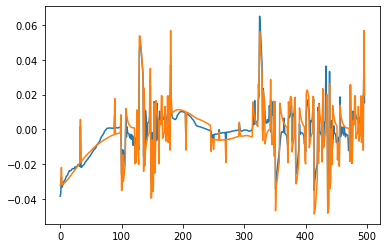

In [91]:
plt.plot(model.predict(X_train))
plt.plot(y_train)

# Plot accuracy and log-loss vs epochs

<AxesSubplot:title={'center':'Loss'}>

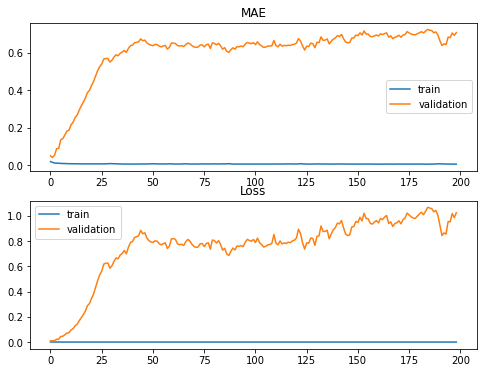

In [92]:
fig,axs = plt.subplots(2,figsize=(8,6))

loss_train = history.history['loss']
loss_val = history.history['val_loss']

metrics_train = history.history['mean_absolute_error']
metrics_val = history.history['val_mean_absolute_error']

pd.Series(metrics_train[1:]).rename('train').plot(legend=True,title='MAE',ax=axs[0])
pd.Series(metrics_val[1:]).rename('validation').plot(legend=True,ax=axs[0])

pd.Series(loss_train[1:]).rename('train').plot(legend=True,title='Loss',ax=axs[1])
pd.Series(loss_val[1:]).rename('validation').plot(legend=True,ax=axs[1])

# Save model in h5 format

In [93]:
model.save("ANN_7AUG_SET1.h5")

# Train Based on Historical Opt

In [143]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="loss",
    max_trials=30,
    executions_per_trial=1,
    overwrite=False,
    directory="my_dir",
    project_name='ANN_7AUG_SET2')

INFO:tensorflow:Reloading Oracle from existing project my_dir\ANN_7AUG_SET2\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\ANN_7AUG_SET2\tuner0.json


In [144]:
tuner.results_summary()

Results summary
Results in my_dir\ANN_7AUG_SET2
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 32
units_hidden: 24
initalizer: zeros
num_hidden: 0
activation_hidden: LeakyReLU
activation: elu
optimizer: adam
dropout: False
rate: 0.5
lr: 0.0025621691991173203
Score: 0.0003024511970579624
Trial summary
Hyperparameters:
units1: 32
units_hidden: 8
initalizer: zeros
num_hidden: 0
activation_hidden: LeakyReLU
activation: LeakyReLU
optimizer: adam
dropout: False
rate: 0.5
lr: 0.001437602322292352
Score: 0.00035436032339930534
Trial summary
Hyperparameters:
units1: 8
units_hidden: 12
initalizer: zeros
num_hidden: 2
activation_hidden: LeakyReLU
activation: LeakyReLU
optimizer: adam
dropout: False
rate: 0.5
lr: 0.03751007397250211
Score: 0.0004060504143126309
Trial summary
Hyperparameters:
units1: 24
units_hidden: 8
initalizer: zeros
num_hidden: 2
activation_hidden: LeakyReLU
activation: LeakyReLU
optimizer: adam
dropout: False
rate: 0.5
lr: 0.00031690000133423763
Score: 0.0005099

## Load saved h5 model

In [112]:
# Read Data Train
df_train = pd.read_csv('...\TRAIN SET SECTION/SET1/Train_set1.csv')
df_test= pd.read_csv(r"...\TRAIN SET SECTION/SET4/Train_set4.csv")

features_col = ['error_rate','yaw_error', 'phi']
targets_col = ['JSRoll_Sim']

X_train = df_train[features_col].values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
transformer = scaler.fit(X_train)
X_train = transformer.transform(X_train)


y_train = df_train[targets_col].values.astype('float32')

# Create  X_test and y_test variable using df_to_array function
X_test = df_test[features_col].values.astype('float32')
X_test = transformer.transform(X_test)
y_test = df_test[targets_col].values.astype('float32')

In [116]:
h5_file_name_load = 'ANN_7AUG_SET2.h5'

# Load Model from h5 file
model = keras.models.load_model(h5_file_name_load)

In [115]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                128       
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________


# SET 1

File Name: Cirrus17.csv


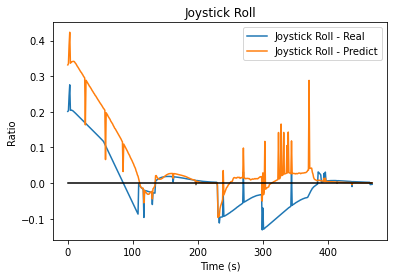

File Name: Cirrus18.csv


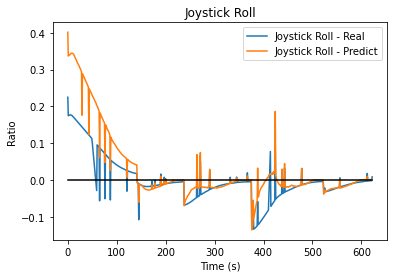

File Name: Cirrus19.csv


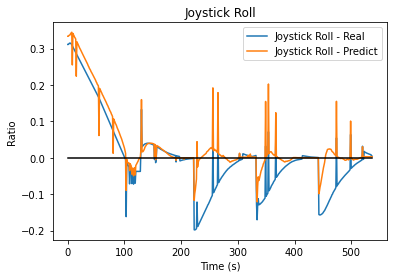

File Name: Cirrus2.csv


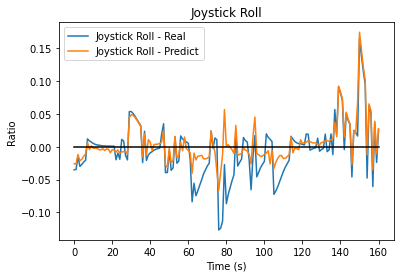

File Name: Cirrus20.csv


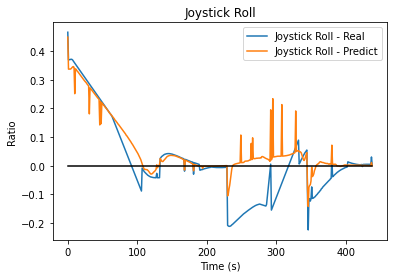

File Name: Cirrus21.csv


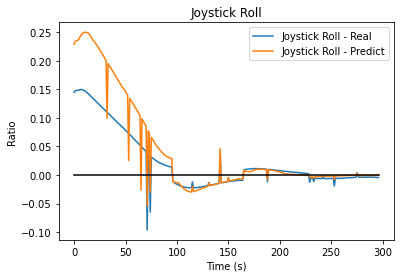

File Name: Cirrus3.csv


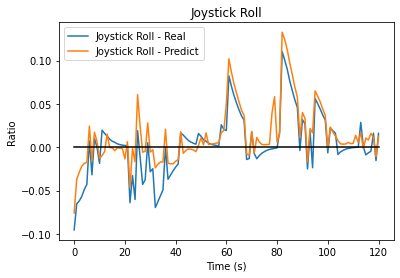

File Name: Cirrus4.csv


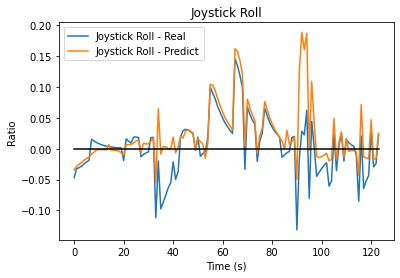

File Name: Cirrus5.csv


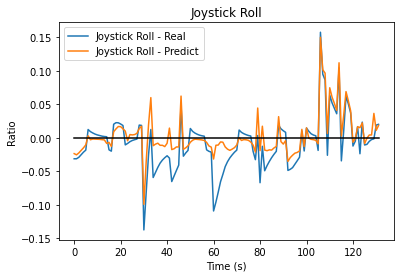

File Name: Cirrus6.csv


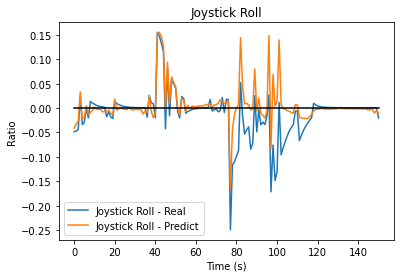

File Name: Train_dataset.csv


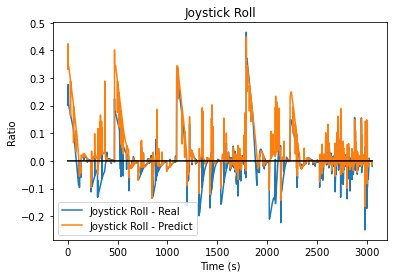

In [94]:
# Import Library
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from numpy import isnan, arange, rad2deg

# Collect all csv file format in choosen directory
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, r"...\CSV PID FINAL PROCESSED\*.csv"))

# Empty list to collect MSE value per file
MSE_left_elv = []
MSE_right_elv = []

# loop over the list of csv files
for f in csv_files:
    
    df_test = pd.read_csv(f)
    
    # Create  X_test and y_test variable using df_to_array function
    X_test = df_test[features_col].values.astype('float32')
    X_test = transformer.transform(X_test)
    y_test = df_test[targets_col].values.astype('float32')

    # Predict X_test using model that have been created
    ail_predicted = model.predict(X_test)

    # Print each file name
    print('File Name:', f.split("\\")[-1])
    
    x_index = [i for i in range(len(df_test))]
    y_index = [0]*len(df_test)

    plt.plot(df_test['JSRoll_Sim'], label='Joystick Roll - Real')
    plt.plot(ail_predicted, label='Joystick Roll - Predict')
    plt.plot(x_index,y_index, 'black')
    plt.title("Joystick Roll")
    plt.xlabel('Time (s)')
    plt.ylabel('Ratio')
    plt.legend(loc='best')

    plt.show()


# SET 2

File Name: Cirrus17.csv


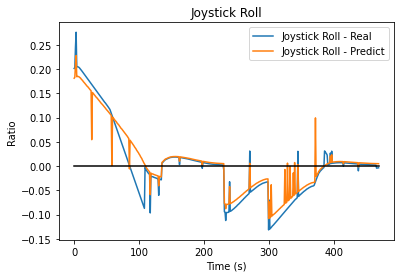

File Name: Cirrus18.csv


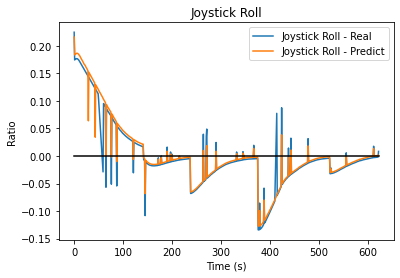

File Name: Cirrus19.csv


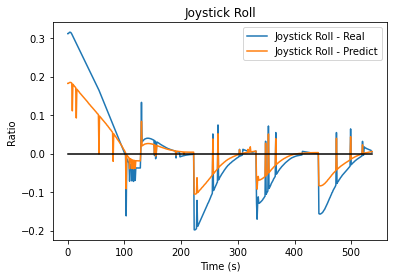

File Name: Cirrus2.csv


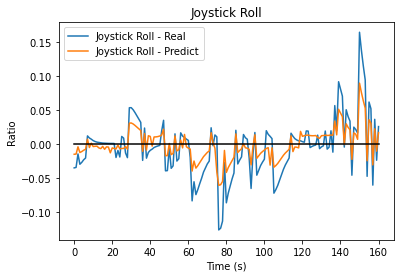

File Name: Cirrus20.csv


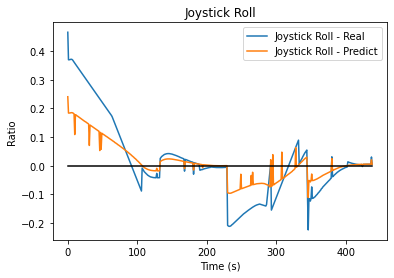

File Name: Cirrus21.csv


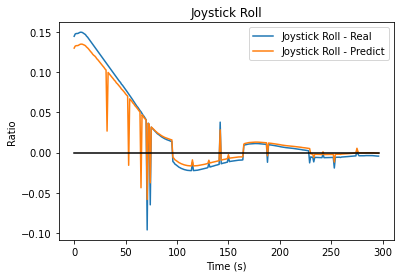

File Name: Cirrus3.csv


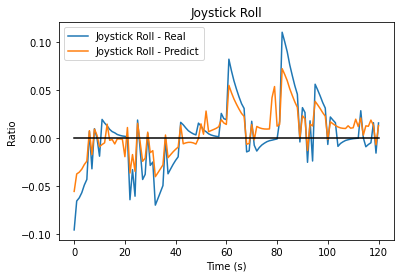

File Name: Cirrus4.csv


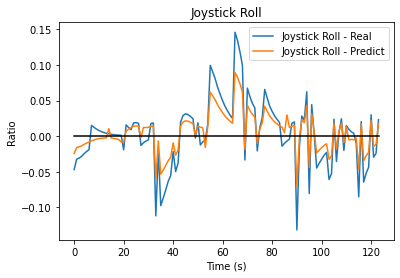

File Name: Cirrus5.csv


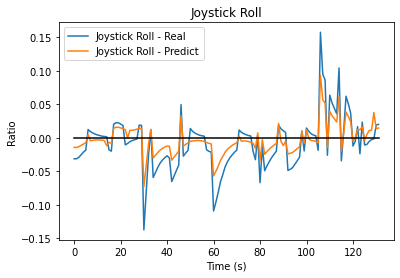

File Name: Cirrus6.csv


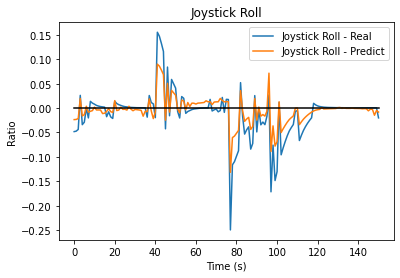

File Name: Train_dataset.csv


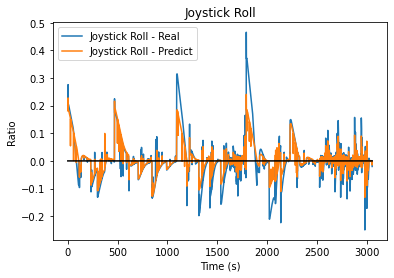

In [70]:
# Import Library
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from numpy import isnan, arange, rad2deg

# Collect all csv file format in choosen directory
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, r"...\CSV PID FINAL PROCESSED\*.csv"))

# Empty list to collect MSE value per file
MSE_left_elv = []
MSE_right_elv = []

# loop over the list of csv files
for f in csv_files:
    
    df_test = pd.read_csv(f)
    
    # Create  X_test and y_test variable using df_to_array function
    X_test = df_test[features_col].values.astype('float32')
    X_test = transformer.transform(X_test)
    y_test = df_test[targets_col].values.astype('float32')

    # Predict X_test using model that have been created
    ail_predicted = model.predict(X_test)

    # Print each file name
    print('File Name:', f.split("\\")[-1])
    
    x_index = [i for i in range(len(df_test))]
    y_index = [0]*len(df_test)

    plt.plot(df_test['JSRoll_Sim'], label='Joystick Roll - Real')
    plt.plot(ail_predicted, label='Joystick Roll - Predict')
    plt.plot(x_index,y_index, 'black')
    plt.title("Joystick Roll")
    plt.xlabel('Time (s)')
    plt.ylabel('Ratio')
    plt.legend(loc='best')

    plt.show()


# SET 3

File Name: Cirrus10.csv


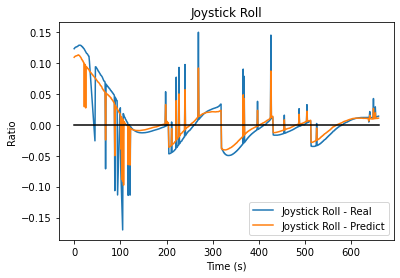

File Name: Cirrus11.csv


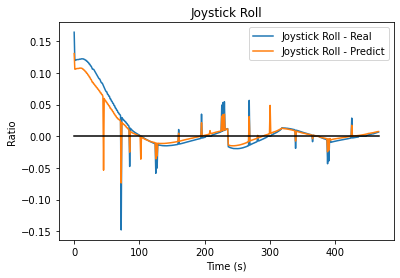

File Name: Cirrus12.csv


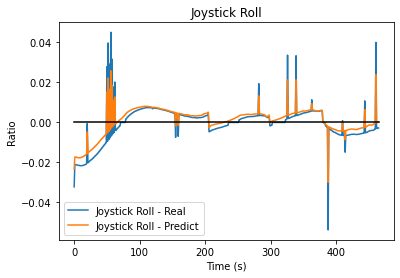

File Name: Cirrus13.csv


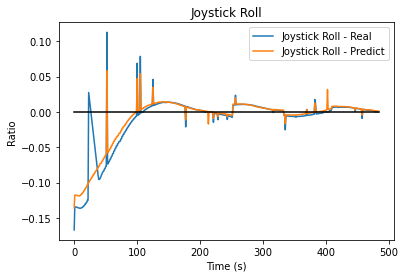

File Name: Cirrus14.csv


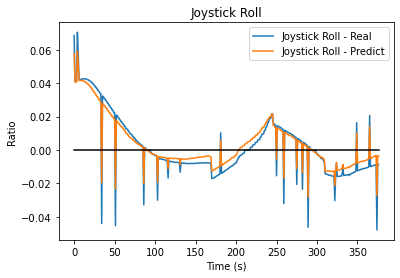

File Name: Cirrus15.csv


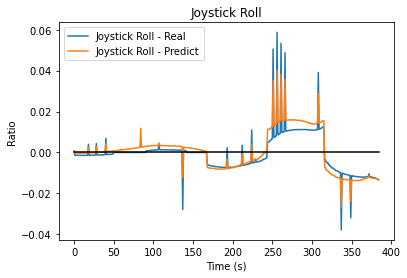

File Name: Cirrus16.csv


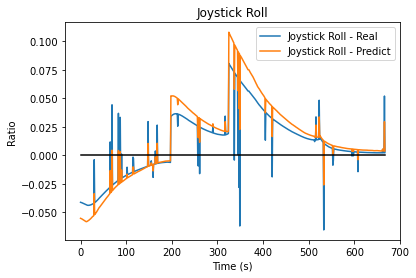

File Name: Cirrus17.csv


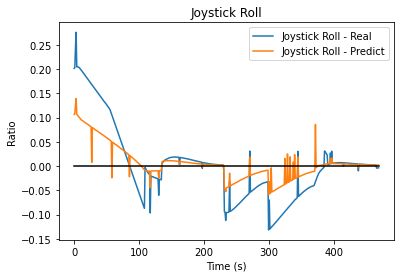

File Name: Cirrus18.csv


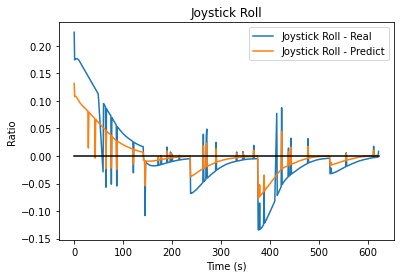

File Name: Cirrus19.csv


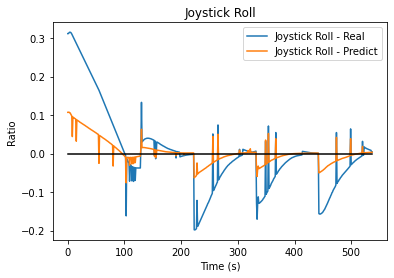

File Name: Cirrus2.csv


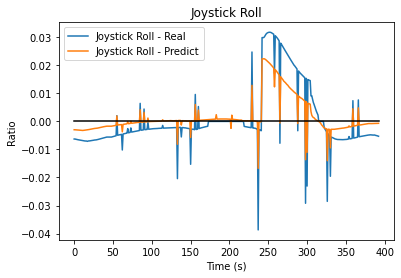

File Name: Cirrus20.csv


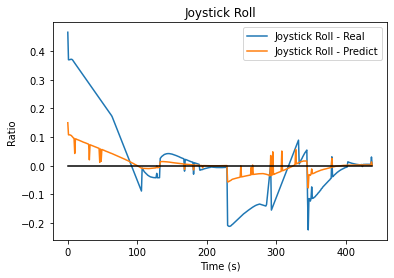

File Name: Cirrus21.csv


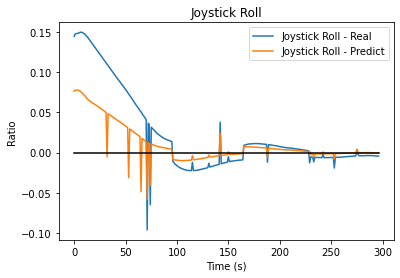

File Name: Cirrus3.csv


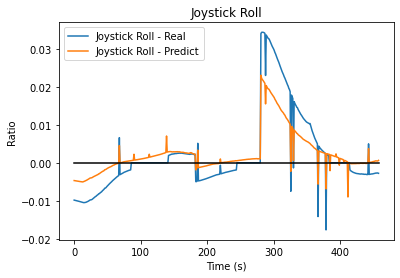

File Name: Cirrus4.csv


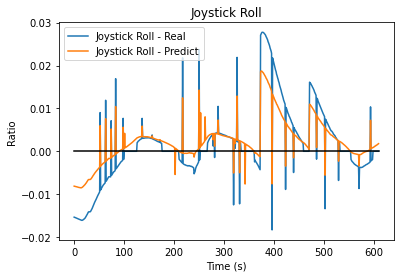

File Name: Cirrus5.csv


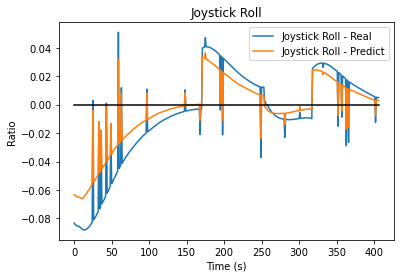

File Name: Cirrus6.csv


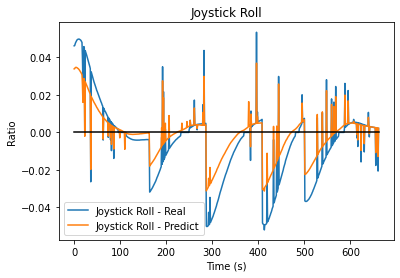

File Name: Cirrus7.csv


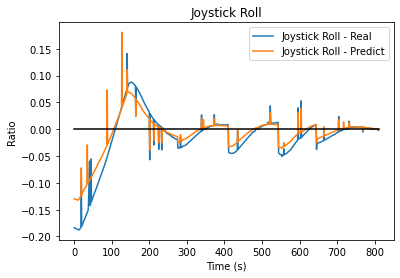

File Name: Cirrus8.csv


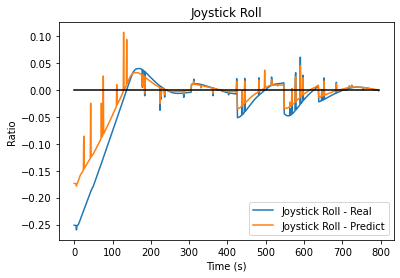

File Name: Cirrus9.csv


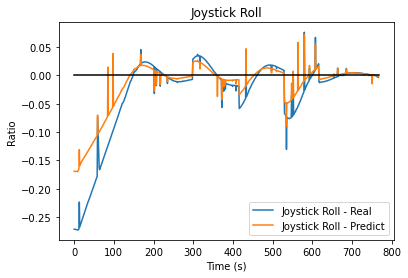

File Name: Train_dataset.csv


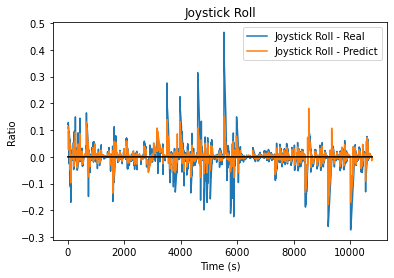

In [203]:
# Import Library
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from numpy import isnan, arange, rad2deg

# Collect all csv file format in choosen directory
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, r"...\CSV PID FINAL PROCESSED\*.csv"))

# Empty list to collect MSE value per file
MSE_left_elv = []
MSE_right_elv = []

# loop over the list of csv files
for f in csv_files:
    
    df_test = pd.read_csv(f)
    
    # Create  X_test and y_test variable using df_to_array function
    X_test = df_test[features_col].values.astype('float32')
    X_test = transformer.transform(X_test)
    y_test = df_test[targets_col].values.astype('float32')

    # Predict X_test using model that have been created
    ail_predicted = model.predict(X_test)

    # Print each file name
    print('File Name:', f.split("\\")[-1])
    
    x_index = [i for i in range(len(df_test))]
    y_index = [0]*len(df_test)

    plt.plot(df_test['JSRoll_Sim'], label='Joystick Roll - Real')
    plt.plot(ail_predicted, label='Joystick Roll - Predict')
    plt.plot(x_index,y_index, 'black')
    plt.title("Joystick Roll")
    plt.xlabel('Time (s)')
    plt.ylabel('Ratio')
    plt.legend(loc='best')

    plt.show()


# SET 4

File Name: Cirrus17.csv


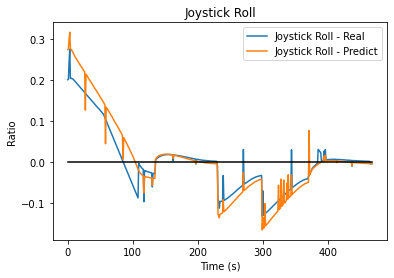

File Name: Cirrus18.csv


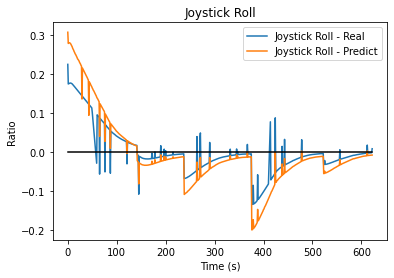

File Name: Cirrus19.csv


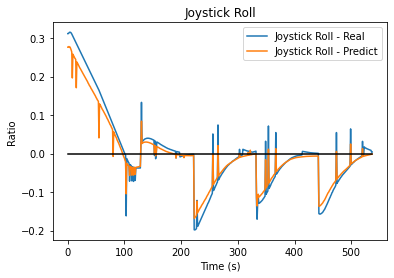

File Name: Cirrus2.csv


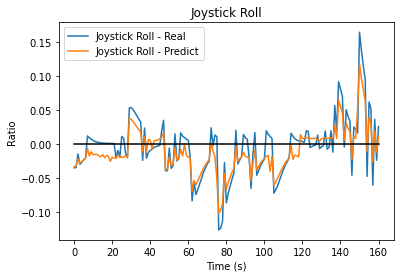

File Name: Cirrus20.csv


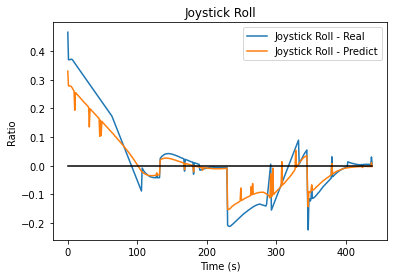

File Name: Cirrus21.csv


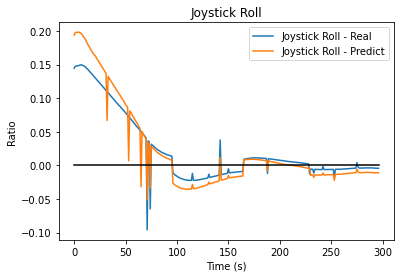

File Name: Cirrus3.csv


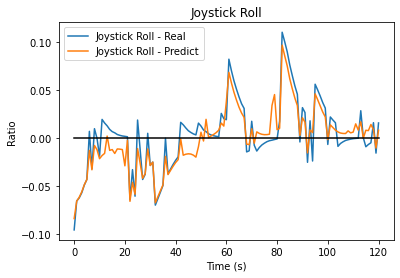

File Name: Cirrus4.csv


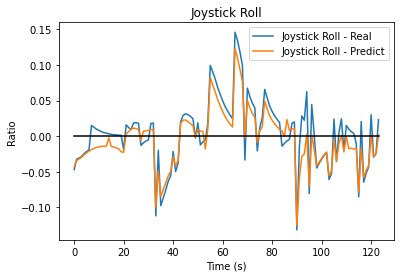

File Name: Cirrus5.csv


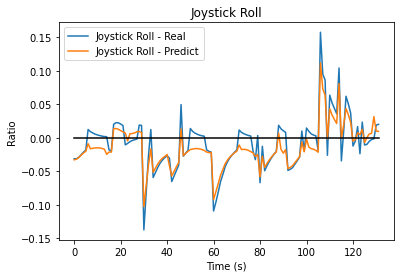

File Name: Cirrus6.csv


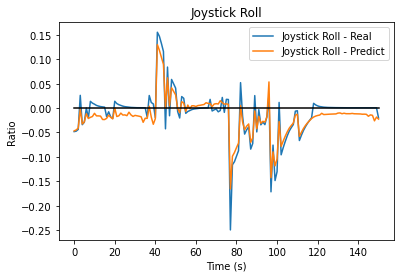

File Name: Train_dataset.csv


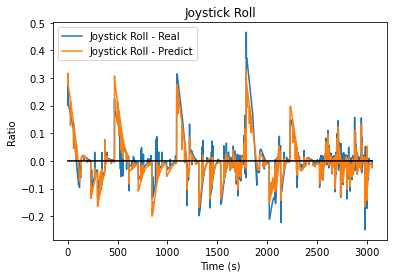

In [26]:
# Import Library
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from numpy import isnan, arange, rad2deg

# Collect all csv file format in choosen directory
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, r"...\CSV PID FINAL PROCESSED\*.csv"))

# Empty list to collect MSE value per file
MSE_left_elv = []
MSE_right_elv = []

# loop over the list of csv files
for f in csv_files:
    
    df_test = pd.read_csv(f)
    
    # Create  X_test and y_test variable using df_to_array function
    X_test = df_test[features_col].values.astype('float32')
    X_test = transformer.transform(X_test)
    y_test = df_test[targets_col].values.astype('float32')

    # Predict X_test using model that have been created
    ail_predicted = model.predict(X_test)

    # Print each file name
    print('File Name:', f.split("\\")[-1])
    
    x_index = [i for i in range(len(df_test))]
    y_index = [0]*len(df_test)

    plt.plot(df_test['JSRoll_Sim'], label='Joystick Roll - Real')
    plt.plot(ail_predicted, label='Joystick Roll - Predict')
    plt.plot(x_index,y_index, 'black')
    plt.title("Joystick Roll")
    plt.xlabel('Time (s)')
    plt.ylabel('Ratio')
    plt.legend(loc='best')
    plt.show()
